### 1. 安装HuggingFace 并下载模型到本地

In [1]:
!pip install huggingface-hub -Uqq
!pip install -Uqq sagemaker

### 如果是外海region，执行下面cell通过huggingface_hub下载, 否则跳过

In [2]:
from huggingface_hub import snapshot_download
from pathlib import Path

local_model_path = Path("./bge-m3-model")
local_model_path.mkdir(exist_ok=True)
model_name = "BAAI/bge-m3"
commit_hash = "4277867103fc67328e2033176de4387b85e9960f"
snapshot_download(repo_id=model_name, revision=commit_hash, cache_dir=local_model_path)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.7k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

imgs/miracl.jpg:   0%|          | 0.00/201k [00:00<?, ?B/s]

imgs/long.jpg:   0%|          | 0.00/218k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

colbert_linear.pt:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

imgs/mkqa.jpg:   0%|          | 0.00/326k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

imgs/nqa.jpg:   0%|          | 0.00/97.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

sparse_linear.pt:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

'bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f'

### 如果是中国区，执行下面cell通过modelscope进行下载

In [ ]:
# !pip install modelscope -i https://pypi.tuna.tsinghua.edu.cn/simple -Uqq

In [ ]:
# from modelscope.hub.snapshot_download import snapshot_download
# from pathlib import Path

# local_model_path = Path("./bge-zh-model")

# local_model_path.mkdir(exist_ok=True)
# model_name = "Xorbits/bge-large-zh-v1.5"
# commit_hash = "v0.0.1"

# snapshot_download(model_name, revision=commit_hash, cache_dir=local_model_path)

### 2. 把模型拷贝到S3为后续部署做准备

In [3]:
import sagemaker
from sagemaker import image_uris
import boto3
import os
import time
import json

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [4]:
s3_model_prefix = "LLM-RAG/workshop/bge-m3-model"  # folder where model checkpoint will go
if region in ['cn-north-1', 'cn-northwest-1']:
    model_snapshot_path = f'{local_model_path}/{model_name}'
else:
    model_snapshot_path = list(local_model_path.glob("**/snapshots/*"))[0]
s3_code_prefix = "LLM-RAG/workshop/bge_m3_deploy_code"
print(f"s3_code_prefix: {s3_code_prefix}")
print(f"model_snapshot_path: {model_snapshot_path}")

s3_code_prefix: LLM-RAG/workshop/bge_m3_deploy_code
model_snapshot_path: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f


In [5]:
!aws s3 cp --recursive {model_snapshot_path} s3://{bucket}/{s3_model_prefix}

upload: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f/config_sentence_transformers.json to s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/config_sentence_transformers.json
upload: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f/.gitattributes to s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/.gitattributes
upload: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f/README.md to s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/README.md
upload: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f/config.json to s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/config.json
upload: bge-m3-model/models--BAAI--bge-m3/snapshots/4277867103fc67328e2033176de4387b85e9960f/1_Pooling/config.json to s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/1_Pooling/config

### 3. 模型部署准备（entrypoint脚本，容器镜像，服务配置）

In [6]:
# inference_image_uri = (
#     f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118"
    
# )

# #中国区需要替换为下面的image_uri
# if region in ['cn-north-1', 'cn-northwest-1']:
#     inference_image_uri = (
#         f"727897471807.dkr.ecr.{region}.amazonaws.com.cn/djl-inference:0.23.0-deepspeed0.9.5-cu118"
#     )

# print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [8]:
inference_image_uri = image_uris.retrieve(framework="djl-lmi", version="0.29.0", region=region)
inference_image_uri

'763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124'

In [9]:
!mkdir -p bge_m3_deploy_code

In [63]:
%%writefile bge_m3_deploy_code/model.py
import logging
import math
import os

import torch
from djl_python import Input, Output
from FlagEmbedding import BGEM3FlagModel
from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer, pipeline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"--device={device}")


def load_model(properties):
    # tensor_parallel = properties["tensor_parallel_degree"]
    model_location = properties["model_dir"]
    if "model_id" in properties:
        model_location = properties["model_id"]
    logging.info(f"Loading model in {model_location}")

    model = BGEM3FlagModel(
        model_location, use_fp16=True
    )  # Setting use_fp16 to True speeds up computation with a slight performance degradation

    return model


model = None
tokenizer = None
generator = None


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0].to(
        device
    )  # First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float().to(device)
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def handle(inputs: Input):
    global model
    if not model:
        model = load_model(inputs.get_properties())

    if inputs.is_empty():
        return None
    data = inputs.get_as_json()

    input_sentences = data["inputs"]
    batch_size = data["batch_size"]
    max_length = data["max_length"]
    return_type = data["return_type"]

    logging.info(f"inputs: {input_sentences}")

    if return_type == "dense":
        encoding_results = model.encode(
            input_sentences, batch_size=batch_size, max_length=max_length
        )
    elif return_type == "sparse":
        encoding_results = model.encode(
            input_sentences,
            return_dense=False,
            return_sparse=True,
            return_colbert_vecs=False,
        )
    elif return_type == "colbert":
        encoding_results = model.encode(
            input_sentences,
            return_dense=False,
            return_sparse=False,
            return_colbert_vecs=True,
        )
    elif return_type == "all":
        encoding_results = model.encode(
            input_sentences,
            batch_size=batch_size,
            max_length=max_length,
            return_dense=True,
            return_sparse=True,
            return_colbert_vecs=True,
        )

    # encoding_results = [encoding_results]

    result = {"sentence_embeddings": encoding_results}
    return Output().add_as_json(result)

Overwriting bge_m3_deploy_code/model.py


In [64]:
print(f"option.model_id ==> s3://{bucket}/{s3_model_prefix}/")

option.model_id ==> s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge-m3-model/


#### Note: option.s3url 为SageMaker部署时使用的模型S3路径

In [65]:
import os

if not os.path.exists("bge_m3_deploy_code"):
    os.mkdir("bge_m3_deploy_code")

with open('bge_m3_deploy_code/serving.properties', 'w') as f:
    f.write("engine=Python")
    f.write("\n")
    f.write("option.tensor_parallel_degree=1")
    f.write("\n")
    f.write(f"option.model_id=s3://{bucket}/{s3_model_prefix}/")

### 【注意】下面这两个Cell，根据region，仅挑选一个执行，否则会产生问题

#### 如果是中国region，执行下面这个cell，在requirements.txt中添加国内的pip镜像

In [66]:
# %%writefile bge_m3_deploy_code/requirements.txt
# -i https://pypi.tuna.tsinghua.edu.cn/simple
# FlagEmbedding

#### 如果是海外region，执行下面这个cell，无需额外添加pip镜像

In [67]:
%%writefile bge_m3_deploy_code/requirements.txt
FlagEmbedding

Overwriting bge_m3_deploy_code/requirements.txt


In [68]:
!rm s2e_model.tar.gz
!cd bge_m3_deploy_code && rm -rf ".ipynb_checkpoints"
!tar czvf s2e_model.tar.gz bge_m3_deploy_code

bge_m3_deploy_code/
bge_m3_deploy_code/serving.properties
bge_m3_deploy_code/model.py
bge_m3_deploy_code/requirements.txt


In [69]:
s3_code_artifact = sess.upload_data("s2e_model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-434444145045/LLM-RAG/workshop/bge_m3_deploy_code/s2e_model.tar.gz


### 4. 创建模型 & 创建endpoint

In [70]:
from sagemaker.utils import name_from_base
import boto3

model_name = name_from_base("bge-m3") #Note: Need to specify model_name
print(model_name)
print(f"Image going to be used is ---- > {inference_image_uri}")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact
    },
    
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

bge-m3-2024-10-08-06-02-35-097
Image going to be used is ---- > 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124
Created Model: arn:aws:sagemaker:us-west-2:434444145045:model/bge-m3-2024-10-08-06-02-35-097


In [71]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1,
            # "VolumeSizeInGB" : 400,
            # "ModelDataDownloadTimeoutInSeconds": 2400,
            "ContainerStartupHealthCheckTimeoutInSeconds": 5*60,
        },
    ],
)
endpoint_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:434444145045:endpoint-config/bge-m3-2024-10-08-06-02-35-097-config',
 'ResponseMetadata': {'RequestId': '5289e651-8ca8-4288-865a-c10ec15dbe51',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5289e651-8ca8-4288-865a-c10ec15dbe51',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '118',
   'date': 'Tue, 08 Oct 2024 06:02:38 GMT'},
  'RetryAttempts': 0}}

In [72]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-west-2:434444145045:endpoint/bge-m3-2024-10-08-06-02-35-097-endpoint


In [73]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:434444145045:endpoint/bge-m3-2024-10-08-06-02-35-097-endpoint
Status: InService


### 6. 创建auto scaling
- 最佳实践参考：https://aws.amazon.com/cn/blogs/machine-learning/optimize-your-machine-learning-deployments-with-auto-scaling-on-amazon-sagemaker/

#### SageMaker 支持托管模型的自动扩展 （Auto Scaling）。  
  
- Auto Scaling 会动态调整为模型预置的实例数，以响应推理工作负载的变化。当工作负载增加时，Auto Scaling 会使更多实例联机。当工作负载减少时，Auto Scaling 会删除不必要的实例，这样您就不必为未使用的预置实例付费。
#### SageMaker 支持三种 Auto Scaling 选项。
- 第一个也是常用的选项是目标跟踪。在此选项中，您可以选择所选 Amazon CloudWatch 指标的理想值，例如要作为目标实现的平均 CPU 利用率或吞吐量，SageMaker 将自动缩减或扩展实例数量以实现目标指标。
- 第二个选项是选择步进扩展，这是一种根据 CloudWatch 警报违规规模进行扩展的高级方法。
- 第三个选项是计划扩展，它允许您指定一个重复计划，以便根据预期需求缩减和扩展终端节点。我们建议您将这些扩展选项组合在一起，以获得更好的弹性。


#### 下图说明了 SageMaker 中的应用程序和扩展设置。
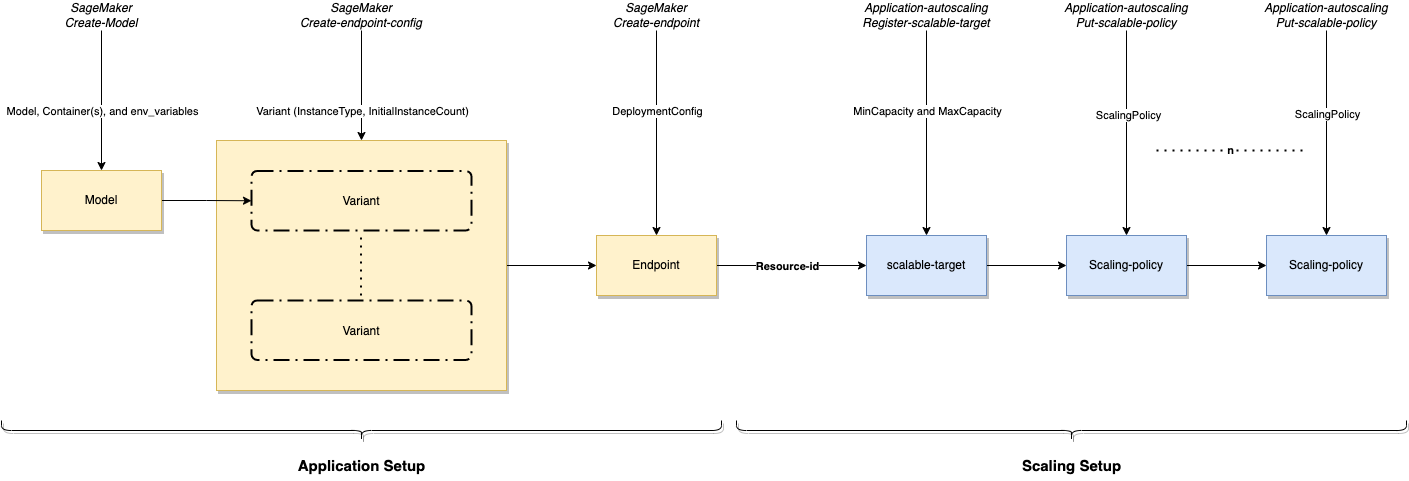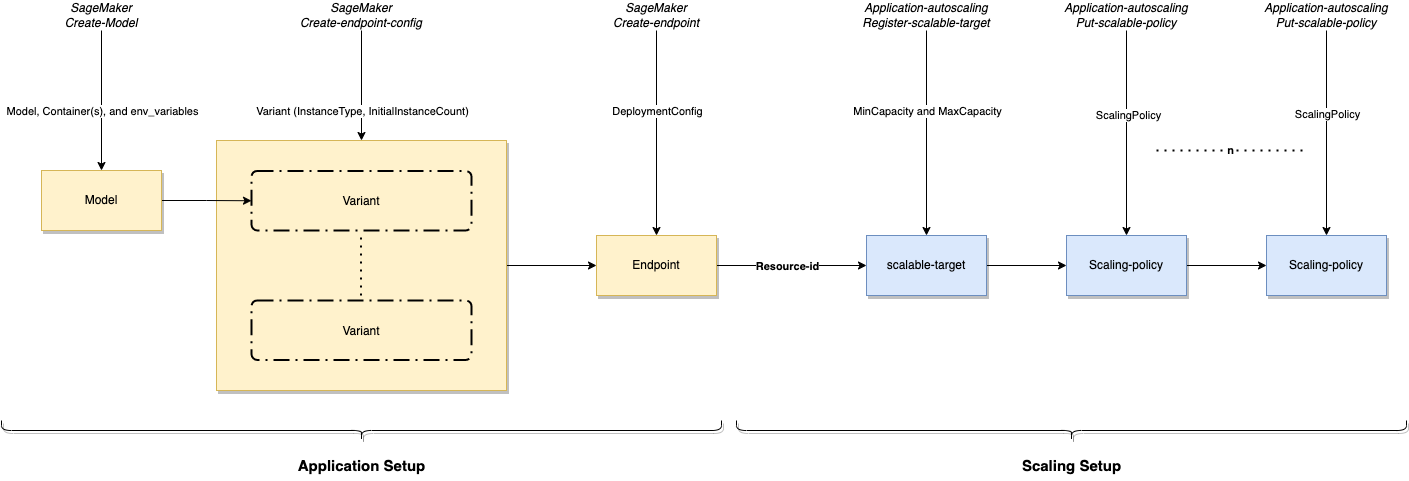

#### 终端节点指标
- 概括地说，这些指标分为三类：调用指标、延迟指标和利用率指标。
- 下图说明了这些指标和终端节点架构。  
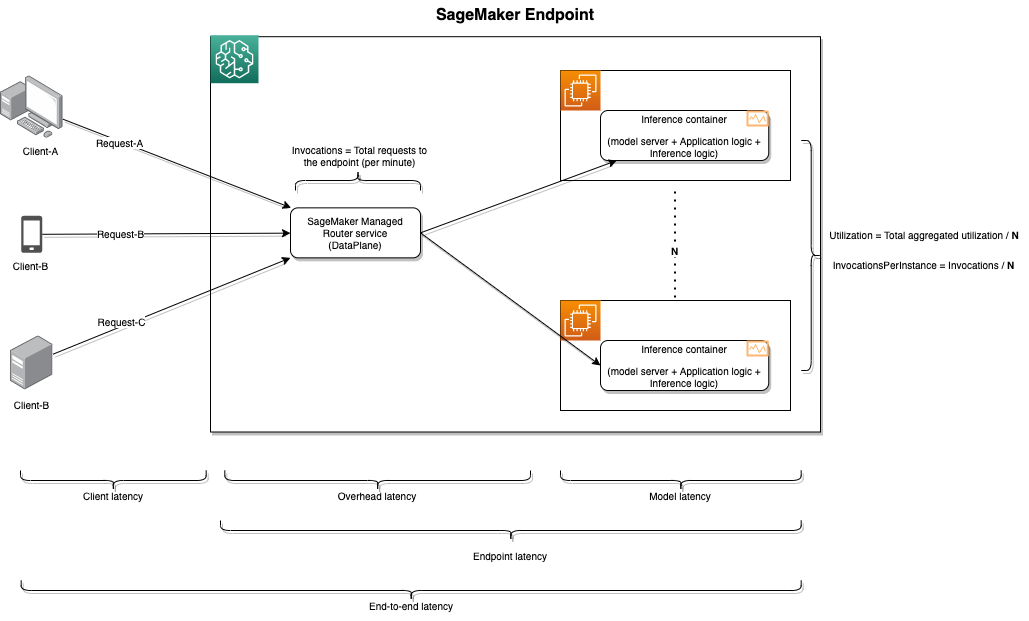


#### 主要指标
1. Invocation metrics 每分钟发送到模型终端节点的 InvokeEndpoint 请求数。
2. InvocationsPerInstance 调用 PerInstance
3. ModelLatency -从 SageMaker 查看的模型响应所用的时间间隔。此间隔包括发送请求和从模型容器获取响应所用的本地通信时间，以及在容器中完成推理所用的时间。
4. OverheadLatency开销延迟 - 根据 SageMaker 开销，添加到响应客户端请求所花费的时间的时间间隔。此间隔是从 SageMaker 收到请求到向客户端返回响应的时间减去
5. Utilization metrics 
   - CPUUtilization / GPUUtilization /MemoryUtilization /GPUMemoryUtilization (1 分钟)

### Scaling plan 制定
#### 扩展计划是一个三步过程，如下图所示：

1. 确定应用程序特征 – 了解所选硬件上应用程序的瓶颈是其中的重要组成部分。
2. 设置扩展预期 – 这涉及确定每秒的最大请求数，以及请求模式的外观 （是平滑的还是尖峰的）。
3. 应用和评估 – 应根据应用程序特征和扩展预期制定扩展策略。作为最后一步的一部分，通过运行预期要处理的负载来评估策略。此外，我们建议迭代最后一步，直到扩展策略可以处理请求负载。
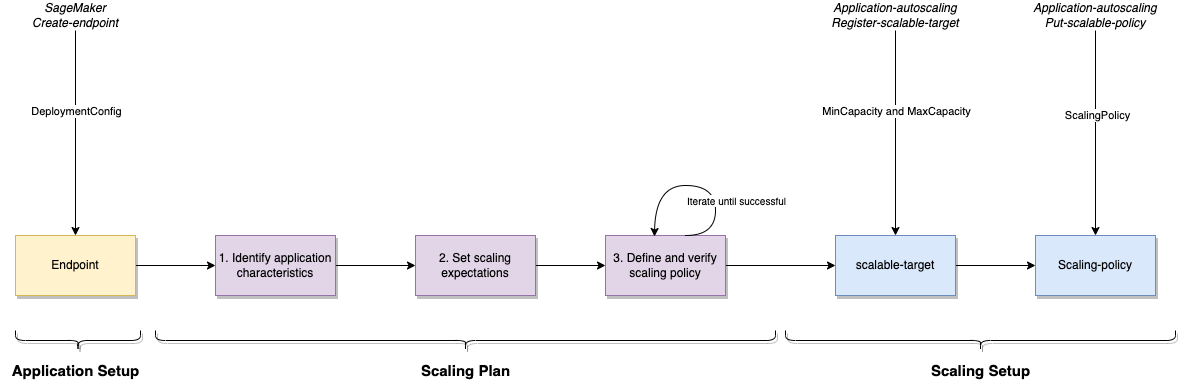

#### 6.1 注册扩容目标
需要将 SageMaker 终端节点变体注册为可扩展目标。指定终端节点的最小和最大容量。对于异步终端节点，可以将最小容量设置为零。

In [75]:
autoscaling = boto3.client('application-autoscaling')

resource_id = f"endpoint/{endpoint_name}/variant/variant1"

#Define the autoscaling policy
response = autoscaling.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=2
)


#### 6.2  定义扩缩策略
使用目标跟踪定义扩展策略。此策略将确定如何根据调用请求等指标触发扩展操作。

- Metrics 参考 ：https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html#cloudwatch-metrics-endpoint-invocation

In [76]:
response = autoscaling.put_scaling_policy(
    PolicyName="Invocations-ScalingPolicy",
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 1.0,  # Target number of invocations per instance
        # "CustomizedMetricSpecification": {
        #     "MetricName": "ApproximateBacklogSizePerInstance",
        #     "Namespace": "AWS/SageMaker",
        #     "Dimensions": [{"Name": "EndpointName", "Value": endpoint_name}],
        #     "Statistic": "Average",
        # },
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance'
        },
        "ScaleInCooldown": 600,  # Cooldown time for scale-in actions
        "ScaleOutCooldown": 300   # Cooldown time for scale-out actions
    }
)

#### 6.3 监控
After setting up the autoscaling configuration, you can monitor the scaling activities through CloudWatch or by using the describe_scalable_targets and describe_scaling_policies methods in Boto3.

In [77]:
# To check scalable targets
scalable_targets = autoscaling.describe_scalable_targets(
    ServiceNamespace='sagemaker'
)

# To check scaling policies
scaling_policies = autoscaling.describe_scaling_policies(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id
)

In [78]:
scaling_policies,scalable_targets

({'ScalingPolicies': [{'PolicyARN': 'arn:aws:autoscaling:us-west-2:434444145045:scalingPolicy:06b83032-5f7a-4107-bf25-b769132bdc76:resource/sagemaker/endpoint/bge-m3-2024-10-08-06-02-35-097-endpoint/variant/variant1:policyName/Invocations-ScalingPolicy',
    'PolicyName': 'Invocations-ScalingPolicy',
    'ServiceNamespace': 'sagemaker',
    'ResourceId': 'endpoint/bge-m3-2024-10-08-06-02-35-097-endpoint/variant/variant1',
    'ScalableDimension': 'sagemaker:variant:DesiredInstanceCount',
    'PolicyType': 'TargetTrackingScaling',
    'TargetTrackingScalingPolicyConfiguration': {'TargetValue': 1.0,
     'PredefinedMetricSpecification': {'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance'},
     'ScaleOutCooldown': 300,
     'ScaleInCooldown': 600},
    'Alarms': [{'AlarmName': 'TargetTracking-endpoint/bge-m3-2024-10-08-06-02-35-097-endpoint/variant/variant1-AlarmHigh-9280042a-bac5-4fcf-84fb-f7664f372742',
      'AlarmARN': 'arn:aws:cloudwatch:us-west-2:434444145045:alarm:Ta

### 5. 模型测试

In [83]:
def get_vector_by_sm_endpoint(questions, sm_client, endpoint_name):
    parameters = {
    }

    response_model = sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "inputs": questions,
                 "batch_size": len(questions),
                "max_length":2000,
                "return_type":"all"
            }
        ),
        ContentType="application/json",
    )
    json_str = response_model['Body'].read().decode('utf8')
    json_obj = json.loads(json_str)
    embeddings = json_obj['sentence_embeddings']
    return embeddings

In [84]:
prompts1=["CUDA 是由 NVIDIA 创建的一个并行计算平台和编程模型，它让开发者可以使用 NVIDIA 的 GPU 进行高性能的并行计算。",
          "NVIDIA GPUs power millions of desktops, notebooks, workstations and supercomputers around the world, accelerating computationally-intensive tasks for consumers, professionals, scientists, and researchers."]
for i in range(1):
    emb = get_vector_by_sm_endpoint(prompts1, smr_client, endpoint_name)

In [41]:
import numpy as np
def cos_sim(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_v1 = np.linalg.norm(vector1)
    norm_v2 = np.linalg.norm(vector2)
    cos_sim = dot_product / (norm_v1 * norm_v2)
    return cos_sim

In [91]:
emb.keys()

dict_keys(['dense_vecs', 'lexical_weights', 'colbert_vecs'])

In [101]:
cos_sim(emb['dense_vecs'][0],emb['dense_vecs'][1])

0.6575192888975284

In [100]:
len(emb['colbert_vecs'][0])

35

In [105]:
emb['lexical_weights'][1]

{'194826': 0.359130859375,
 '162808': 0.325439453125,
 '7': 0.2054443359375,
 '14537': 0.284912109375,
 '43077': 0.2130126953125,
 '111': 0.1492919921875,
 '86983': 0.2353515625,
 '4': 0.093017578125,
 '74305': 0.2216796875,
 '4488': 0.11273193359375,
 '41311': 0.1810302734375,
 '136': 0.060638427734375,
 '1601': 0.150390625,
 '164511': 0.227294921875,
 '10932': 0.1341552734375,
 '8999': 0.169677734375,
 '197108': 0.2099609375,
 '214': 0.142578125,
 '181135': 0.1702880859375,
 '43315': 0.07598876953125,
 '29272': 0.162109375,
 '29888': 0.0716552734375,
 '66211': 0.199951171875,
 '100': 0.11968994140625,
 '107222': 0.193115234375,
 '50582': 0.143310546875,
 '172647': 0.1378173828125,
 '25188': 0.14013671875,
 '1314': 0.08172607421875,
 '5': 0.073486328125}

#### 清除模型Endpoint和config （如无需要，不要执行）

In [ ]:
!aws sagemaker delete-endpoint --endpoint-name bge-large-en-2023-08-16-09-58-49-900-endpoint

In [ ]:
!aws sagemaker delete-endpoint-config --endpoint-config-name bge-large-en-2023-08-16-09-58-49-900-config

In [ ]:
!aws sagemaker delete-model --model-name bge-large-en-2023-08-16-09-58-49-900